# Echo State Network
Here, we validate the hyperparameters of the ESN. Note that the ESN is only trained on the encoded latent space representation. 

In [1]:
import matplotlib as mpl
import pickle
import json
import time
from pathlib import Path
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
import warnings
import torchinfo
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device("cpu")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from neuralnetwork.autoencoder import CAE
from neuralnetwork.preprocessing import generate_esn_noise_data, train_valid_test_split
from neuralnetwork.LongShortTermMemory import SequentialTimeSeriesDataset, torchLSTM
from neuralnetwork.preprocessing import normalize_data, train_valid_test_split
from neuralnetwork.earlystopping import EarlyStopper
from neuralnetwork.losses import LossTracker

#### 1: Load the trained CAE and the encoded time series

In [2]:
cae_path = Path('../weights/fluent-sweep-2/')
with open(cae_path/'ks.json') as f:
    ks_data = json.load(f)
print(ks_data)

with open(cae_path /'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)
print(f"Encoded timeseries {U_encoded.shape}")

{'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.05, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.04}
Encoded timeseries (499751, 8)


#### 2: Prepare the encoded data for the ESN training

In [33]:
ks_data['train_ratio'] = 0.5

In [34]:
U_train_series, U_valid_series, U_test_series = train_valid_test_split(U_encoded, ks_data)
print(f"Data split: {U_train_series.shape, U_valid_series.shape, U_test_series.shape}")

batch_size = 256  # Choose your desired batch size
window_size =20  # Choose your desired window size
train_dataset = SequentialTimeSeriesDataset(U_train_series, batch_size, window_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = SequentialTimeSeriesDataset(U_valid_series, batch_size, window_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


for input, label in train_loader:
    print(f"LSTM takes inputs: (batch size, window size, dimension of observations)")
    print(f"Input shape {input.shape} \nLabel shape {label.shape}")
    break

Data split: ((200000, 8), (40000, 8), (259751, 8))
LSTM takes inputs: (batch size, window size, dimension of observations)
Input shape torch.Size([256, 20, 8]) 
Label shape torch.Size([256, 20, 8])


In [9]:
lstm = torchLSTM(input_size=8, hidden_size=100, window_size=20, device=device)
torchinfo.summary(lstm, input_size=(256, 20, 8))

Layer (type:depth-idx)                   Output Shape              Param #
torchLSTM                                [256, 20, 8]              --
├─LSTM: 1-1                              [256, 20, 100]            44,000
├─Linear: 1-2                            [256, 20, 8]              808
Total params: 44,808
Trainable params: 44,808
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 225.49
Input size (MB): 0.16
Forward/backward pass size (MB): 4.42
Params size (MB): 0.18
Estimated Total Size (MB): 4.77

In [10]:

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# Define the number of epochs and the gamma parameter for the scheduler
epochs = 10
gamma = 0.999

# Create an instance of ExponentialLR and associate it with your optimizer
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
loss_tracker = LossTracker(len(train_loader), len(valid_loader))

early_stopper = EarlyStopper(patience=200, min_delta=1e-6)
weighing_dissipation = 1
lstm = lstm.to(device)
# wandb.watch(model)
best_model_state_dict = lstm.state_dict()  # Save the best model state_dict
patience = 100
training_losses_per_epoch = []
validation_losses_per_epoch = []
best_validation_loss = float('inf')

In [35]:

# Define the number of epochs and the gamma parameter for the scheduler
epochs = 10
gamma = 0.999

# Create an instance of ExponentialLR and associate it with your optimizer
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
loss_tracker = LossTracker(len(train_loader), len(valid_loader))


for epoch in range(epochs): 
    loss_tracker.set_start_time(time.time())
    loss_tracker.reset_current_loss()

    # Training loop
    lstm.train()
    loss_tracker.set_start_time(time.time())
    loss_tracker.reset_current_loss()

    # Training loop
    lstm.train()
    for step, [x_batch_train, y_batch_train] in enumerate(train_loader):
        x_batch_train = x_batch_train.float().to(device)
        y_batch_train = y_batch_train.float().to(device)
        optimizer.zero_grad()
        output = lstm(x_batch_train.to(device))
        loss = criterion(output, y_batch_train)
        loss.backward()
        optimizer.step()
        loss_tracker.update_current_loss('training', loss)
    loss_tracker.print_current_loss(epoch, 'training')

    loss_tracker.set_start_time(time.time())
    scheduler.step()
    # Validation loop
    lstm.eval()
    with torch.no_grad():
        for valid_step, [x_batch_valid, y_batch_valid] in enumerate(valid_loader):
            x_batch_valid = x_batch_valid.float().to(device)
            y_batch_valid = y_batch_valid.float().to(device)
            output = lstm(x_batch_valid)
            loss = criterion(output, y_batch_valid)
            loss_tracker.update_current_loss('validation', loss)

    loss_tracker.print_current_loss(epoch, 'validation')
    loss_tracker.calculate_and_store_average_losses()

    if loss_tracker.check_best_validation_loss():
        early_stopper.reset_counter()
        best_model_state_dict = lstm.state_dict()  # the best model state_dict
        # torch.save(model.state_dict(), modelpath/'best_model.pth')  # Save the best model
        print('Saved best model')
    if early_stopper.track(loss_tracker.get_current_validation_loss()):
        break

training; epoch 0; time 78.03s 
total loss 1.05e-05
validation; epoch 0; time 6.35s 
total loss 7.11e-06
Saved best model


KeyboardInterrupt: 

In [36]:
# take a random time window from the test data
N_start = np.random.randint(len(U_test_series)-10000)
single_window = np.reshape(U_test_series[N_start:N_start+window_size, :], newshape=(1, window_size, 8))

In [37]:

vmin = -1
vmax=1
N_start = 1000
N_plot=5000
test_snapshot = torch.from_numpy(U_test_series[N_start:N_start+window_size]).float()[np.newaxis]
label_snapshot = torch.from_numpy(U_test_series[N_start+1:N_start+1+N_plot+window_size]).float()
prediction = lstm.closed_loop_prediction(test_snapshot.to(device), prediction_length=N_plot)

In [38]:
cae_model = CAE(8)
cae_model.load_state_dict(torch.load(cae_path/"best_model.pth", map_location=device))
cae_model = cae_model.to(device)

In [39]:

# Define constants
N_lyap = int(1/ks_data["lyap"]/(ks_data["dt"]*ks_data["upsample"]))
N_plot = 10*N_lyap
cmap = 'RdBu_r'
fs = 14
# Calculate domain length
domain_length = 8 * np.pi
lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (ks_data["dt"]*ks_data["upsample"]))

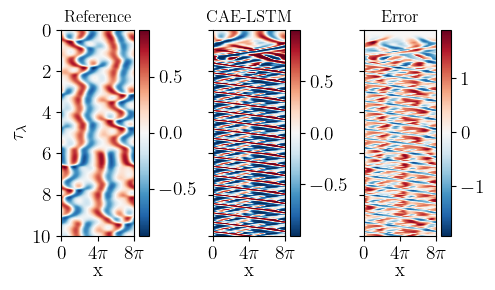

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1

# Extract data
data1 = cae_model.decoder(label_snapshot).numpy(force=True)[:N_plot, 0, :] 
data2 = cae_model.decoder(prediction[0]).numpy(force=True)[:N_plot, 0, :] 
data3 = data1 - data2

lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (ks_data["dt"]*ks_data["upsample"]))
# Adjust subplot spacing
plt.subplots_adjust(wspace=-0.05)  #
# Plot data
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data, aspect='auto', cmap=cmap,
                     extent=[0, 2 * 4 * np.pi, int(lyapunov_time[N_plot]), lyapunov_time[0]])


    axes.set_xlabel('x', fontsize=fs, rotation=0, labelpad=0, y=0.46)
     # Set y-tick labels and font size
    axes.set_yticks(axes.get_yticks())  # Ensure yticks are set first
    axes.set_yticklabels([f'{int(tick)}' for tick in axes.get_yticks()], fontsize=fs)

    axes.yaxis.tick_left()
    axes.set_xticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)), ['0', r'$4\pi$', r'8$\pi$'],
                    fontsize=fs)
    for tick_label in axes.get_xticklabels():
        tick_label.set_ha('center')
        tick_label.set_x(-0.05)

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=fs)

axs[0].set_ylabel(r'$\tau_{\lambda}$', fontsize=fs)
axs[0].set_title("Reference")
axs[1].set_title("CAE-LSTM")
axs[2].set_title("Error")
# Show or save plot
plt.tight_layout()
# plt.savefig("../images/cae-esn.png", dpi=100)fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1